### dataset 특징 확인

In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv('./train.csv')

In [7]:
df.head()

,leaktype,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,...,5030HZ,5040HZ,5050HZ,5060HZ,5070HZ,5080HZ,5090HZ,5100HZ,5110HZ,5120HZ
0,out,0,2,2,0,2,0,2,2,2,...,2,5,2,2,5,2,2,5,2,5
1,out,0,0,0,3,0,3,0,0,0,...,0,3,3,3,3,3,3,3,3,6
2,out,0,4,4,4,4,5,4,4,5,...,5,5,6,5,6,6,6,5,6,4
3,out,0,6,5,5,6,5,6,6,5,...,6,6,7,7,5,6,5,5,7,7
4,out,0,3,0,0,3,0,0,3,3,...,3,3,3,3,3,3,3,3,3,3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33600 entries, 0 to 33599
Columns: 514 entries, leaktype to 5120HZ
dtypes: int64(513), object(1)
memory usage: 131.8+ MB


In [9]:
df.isnull().sum()  #missing value 확인

leaktype    0
0HZ         0
10HZ        0
20HZ        0
30HZ        0
           ..
5080HZ      0
5090HZ      0
5100HZ      0
5110HZ      0
5120HZ      0
Length: 514, dtype: int64

### 데이터 정규화

In [10]:
df_scaled = df

from sklearn.preprocessing import StandardScaler

scale_cols = df_scaled[df_scaled.columns.difference(['leaktype'])].columns

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled, columns=scale_cols)

df_scaled['leaktype'] = df['leaktype'].values 

In [11]:
df_scaled.head()

,0HZ,1000HZ,100HZ,1010HZ,1020HZ,1030HZ,1040HZ,1050HZ,1060HZ,1070HZ,...,910HZ,920HZ,930HZ,940HZ,950HZ,960HZ,970HZ,980HZ,990HZ,leaktype
0,0.0,-0.738014,-0.511539,-0.706901,-0.612977,-0.617985,-0.323865,-0.618441,-0.663783,-0.695004,...,-0.816247,-0.804978,-0.407450,-0.773154,-0.728035,-0.713297,-0.737824,-0.723509,-0.364140,out
1,0.0,-0.615149,-0.672447,-0.590434,-0.520266,-0.519881,-0.515989,-0.521246,-0.240315,-0.248658,...,-0.685252,-0.674060,-1.059178,-1.026528,-0.609093,-0.946242,-0.983801,-0.602778,-0.606415,out
2,0.0,-0.369418,-0.270177,-0.357501,-0.242133,-0.323672,-0.419927,-0.229663,-0.134448,-0.360245,...,-0.292267,-0.412224,-0.277105,-0.266408,-0.371209,-0.247407,-0.368859,-0.361316,-0.121866,out
3,0.0,-0.369418,-0.189723,-0.357501,-0.427555,-0.323672,-0.419927,-0.424052,-0.346182,-0.471831,...,-0.554257,-0.412224,-0.537796,-0.393094,-0.371209,-0.480352,-0.368859,-0.361316,-0.485278,out
4,0.0,-0.615149,-0.028815,-0.590434,-0.520266,-0.519881,-0.515989,-0.812830,-0.557916,-0.583417,...,-0.685252,-0.674060,-0.668141,-0.646468,-0.609093,-0.596824,-0.614836,-0.602778,-0.606415,out


### input, output 분리

In [12]:
feature_df = df_scaled[df_scaled.columns.difference(['leaktype'])]
label_df = df_scaled['leaktype']

In [13]:
label_df.head()

0    out
1    out
2    out
3    out
4    out
Name: leaktype, dtype: object

In [14]:
label_df = label_df.replace('other', 0)
label_df = label_df.replace('noise', 1)
label_df = label_df.replace('normal', 2)
label_df = label_df.replace('in', 3)
label_df = label_df.replace('out', 4)

In [15]:
label_df

0        4
1        4
2        4
3        4
4        4
        ..
33595    1
33596    1
33597    1
33598    1
33599    1
Name: leaktype, Length: 33600, dtype: int64

In [16]:
feature_np = feature_df.to_numpy().astype('float32')
label_np = label_df.to_numpy().astype('float32')

### 데이터 shuffle

In [17]:
s = np.arange(len(feature_np))

np.random.shuffle(s)

feature_np = feature_np[s]
label_np = label_np[s]

### train data, validation data 분리

In [18]:
split = 0.15

test_num = int(split*len(label_np))

x_test = feature_np[0:test_num]
y_test = label_np[0:test_num]

x_train = feature_np[test_num:]
y_train = label_np[test_num:]

### hidden layer with 128 node

In [34]:
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Input

model = Sequential()

model.add(Dense(128, activation='sigmoid', input_shape=(x_train.shape[-1],)))
model.add(Dense(1, activation='linear')) 

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), 
              loss='mse', metrics=['mae', tfa.metrics.F1Score(1, average='macro')])

In [36]:
from datetime import datetime

start_time = datetime.now()

hist = model.fit(x_train, y_train, epochs=500, validation_data = (x_test, y_test))

end_time = datetime.now()

print('\nElapsed Time => ', end_time - start_time)

Epoch 1/500
893/893 [==============================] - 3s 3ms/step - loss: 0.7219 - mae: 0.5506 - f1_score: 1.2282 - val_loss: 0.7459 - val_mae: 0.5584 - val_f1_score: 1.2356
Epoch 2/500
893/893 [==============================] - 3s 3ms/step - loss: 0.7194 - mae: 0.5501 - f1_score: 1.2282 - val_loss: 0.7387 - val_mae: 0.5473 - val_f1_score: 1.2356
Epoch 3/500
893/893 [==============================] - 3s 3ms/step - loss: 0.7168 - mae: 0.5479 - f1_score: 1.2282 - val_loss: 0.7396 - val_mae: 0.5550 - val_f1_score: 1.2356
Epoch 4/500
893/893 [==============================] - 3s 3ms/step - loss: 0.7142 - mae: 0.5480 - f1_score: 1.2282 - val_loss: 0.7415 - val_mae: 0.5603 - val_f1_score: 1.2356
Epoch 5/500
893/893 [==============================] - 3s 3ms/step - loss: 0.7117 - mae: 0.5469 - f1_score: 1.2282 - val_loss: 0.7359 - val_mae: 0.5491 - val_f1_score: 1.2356
Epoch 6/500
893/893 [==============================] - 3s 3ms/step - loss: 0.7097 - mae: 0.5458 - f1_score: 1.2282 - val_loss

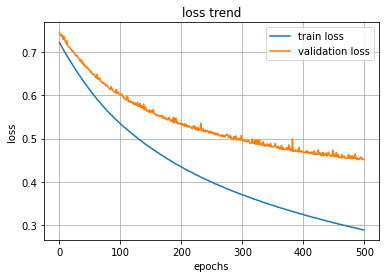

In [37]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.show()

#### 최종 결과 : train_loss 0.2890 validation loss 0.4517 f1 score은 뭔가 이상함

In [ ]:
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))